In [1]:
import torch
import numpy as np
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet
from utils import *

setup_random_seeds(42)
device = get_device()

# Load data
base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# Normalization stats from training set
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
_, min_vals, max_vals = min_max_normalize(x_train)

# Find best sample index (clean samples only)
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx = np.where(clean_mask)[0]

# Load model
model = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4).to(device)
checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Quick R² scan to find best sample
from sklearn.metrics import r2_score

r2_vals = []
with torch.no_grad():
    for idx in clean_idx:
        x_ssh = torch.from_numpy(test.ssh.values[idx]).float().unsqueeze(0).unsqueeze(0).to(device)
        x_sst = torch.from_numpy(test.sst.values[idx]).float().unsqueeze(0).unsqueeze(0).to(device)
        x = torch.cat([x_ssh, x_sst], dim=1)
        x_norm, _, _ = min_max_normalize(x, min_vals, max_vals)
        
        output = model(x_norm)
        mu_zca = output[:, 0:1, ...]
        ubm_pred = apply_inverse_zca_whitening_4d_torch(mu_zca, Vt, scale, mean)
        
        pred = ubm_pred.squeeze().cpu().numpy().ravel()
        truth = test.ubm.values[idx].ravel()
        mask = np.isfinite(truth) & np.isfinite(pred)
        r2_vals.append(r2_score(truth[mask], pred[mask]))

best_local = np.argmax(r2_vals)
sample_idx = clean_idx[best_local]
print(f"Best sample: {sample_idx}, R²={r2_vals[best_local]:.4f}")

# Now extract all schematic fields for this one sample
with torch.no_grad():
    x_ssh = torch.from_numpy(test.ssh.values[sample_idx]).float().unsqueeze(0).unsqueeze(0).to(device)
    x_sst = torch.from_numpy(test.sst.values[sample_idx]).float().unsqueeze(0).unsqueeze(0).to(device)
    x = torch.cat([x_ssh, x_sst], dim=1)
    x_norm, _, _ = min_max_normalize(x, min_vals, max_vals)
    
    output = model(x_norm)
    mu_zca = output[0, 0].cpu().numpy()
    log_sigma_zca = output[0, 1].cpu().numpy()
    sigma_zca = np.exp(log_sigma_zca)
    
    # Inverse ZCA for mean prediction
    ubm_pred = apply_inverse_zca_whitening_4d_torch(output[:, 0:1, ...], Vt, scale, mean)
    ubm_pred = ubm_pred.squeeze().cpu().numpy()

# Collect all fields
ssh = test.ssh.values[sample_idx]
sst = test.sst.values[sample_idx]
ubm_true = test.ubm.values[sample_idx]
bm_pred = ssh - ubm_pred
bm_true = ssh - ubm_true

Using device: cuda


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:255: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x78617711d310>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:255: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x78617711d310>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:255: ZarrUserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x78617711d310>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


Best sample: 3041, R²=0.9127


In [17]:
np.min(mu_zca)

np.float32(-14.101654)

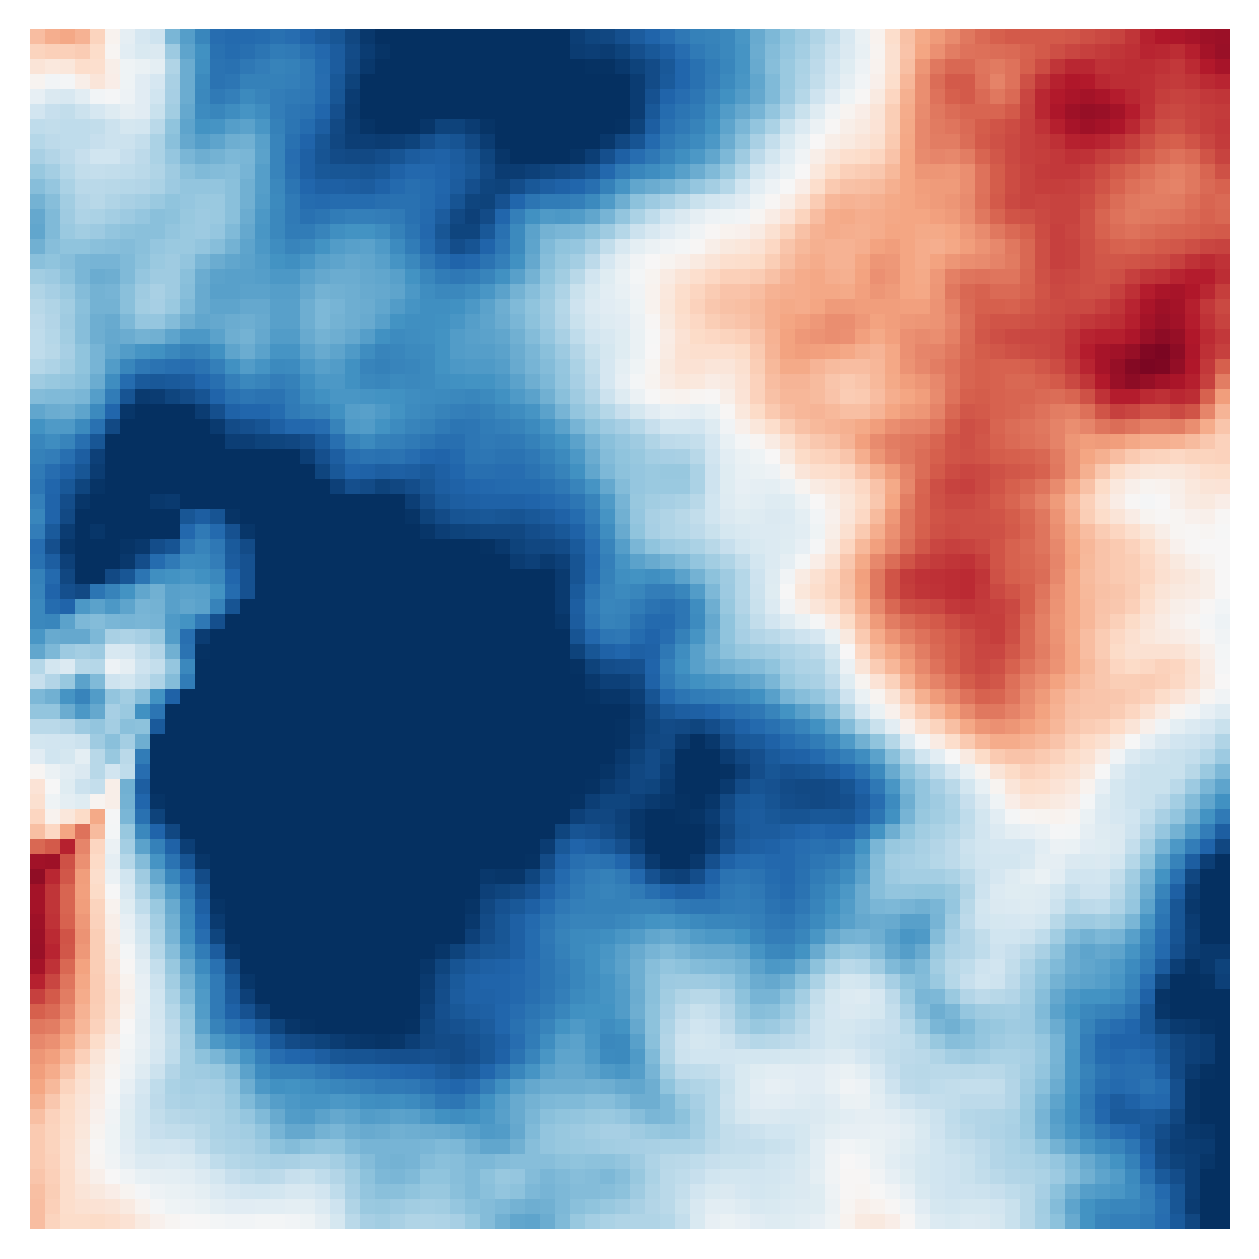

Saved schematic_ssh_input.png


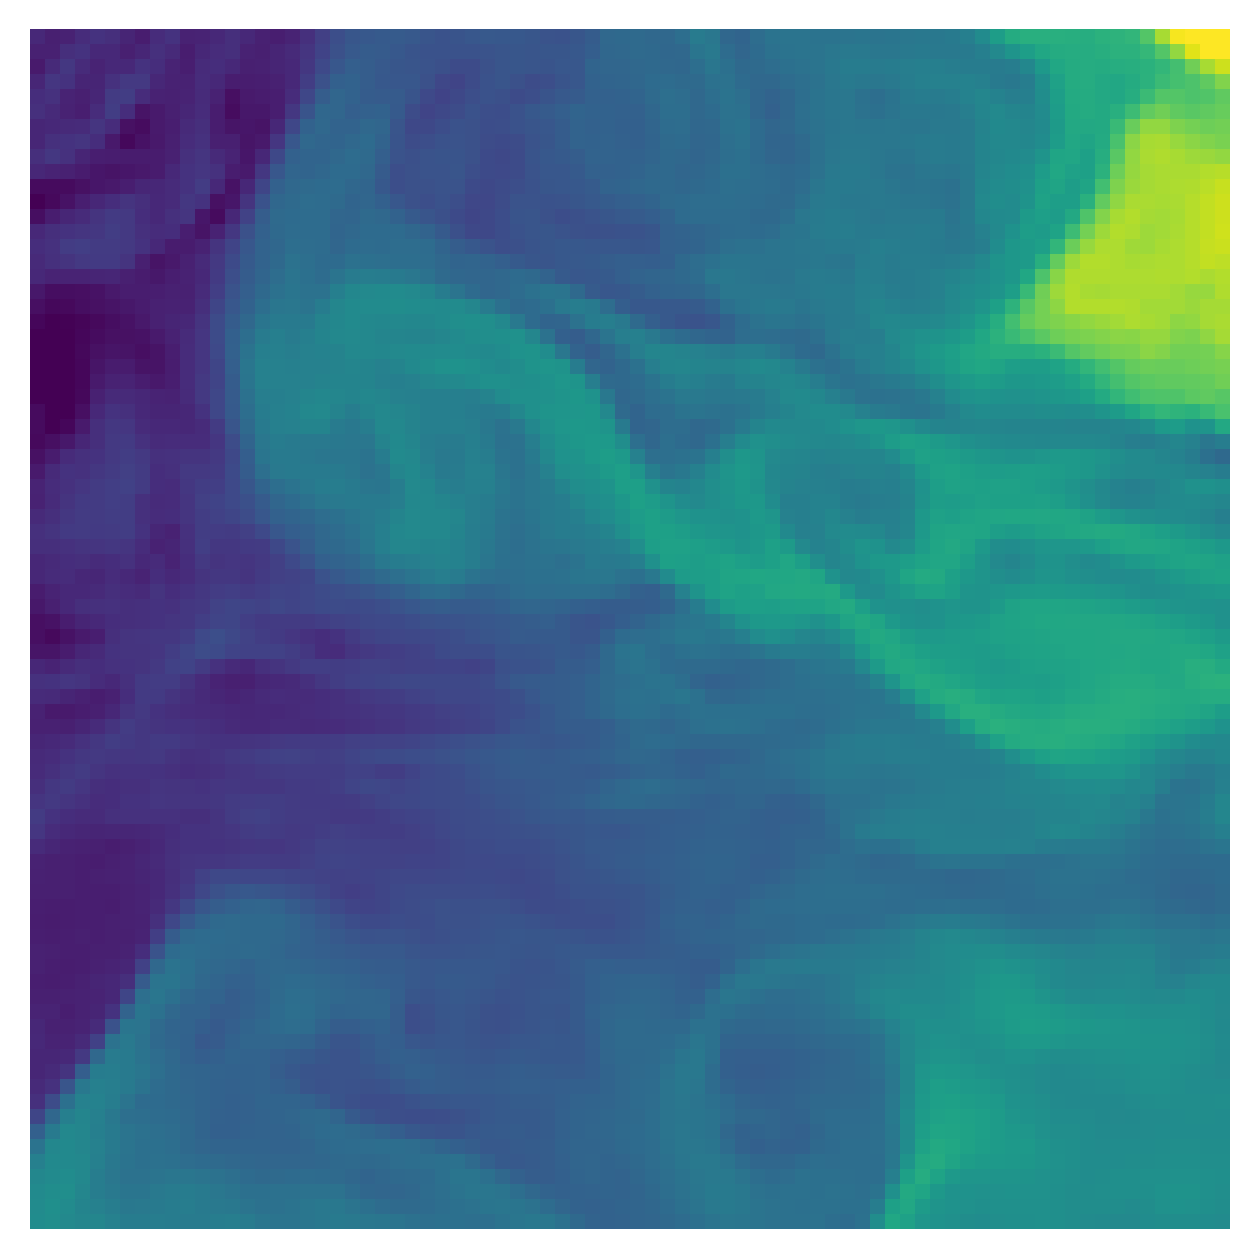

Saved schematic_sst_input.png


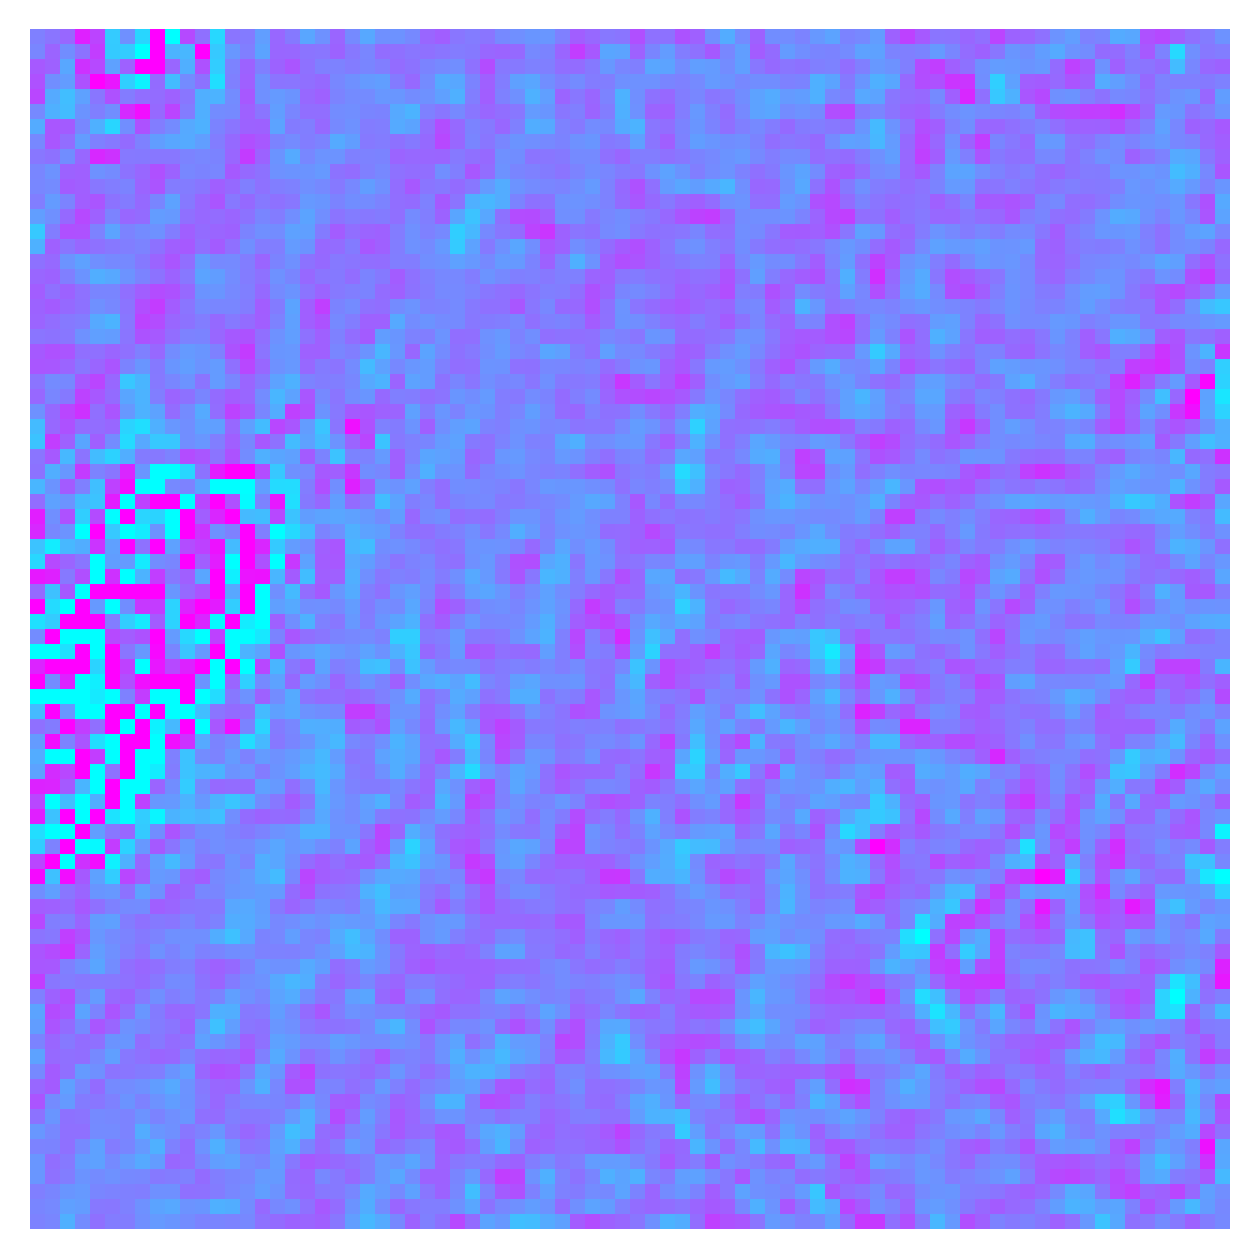

Saved schematic_mu_zca.png


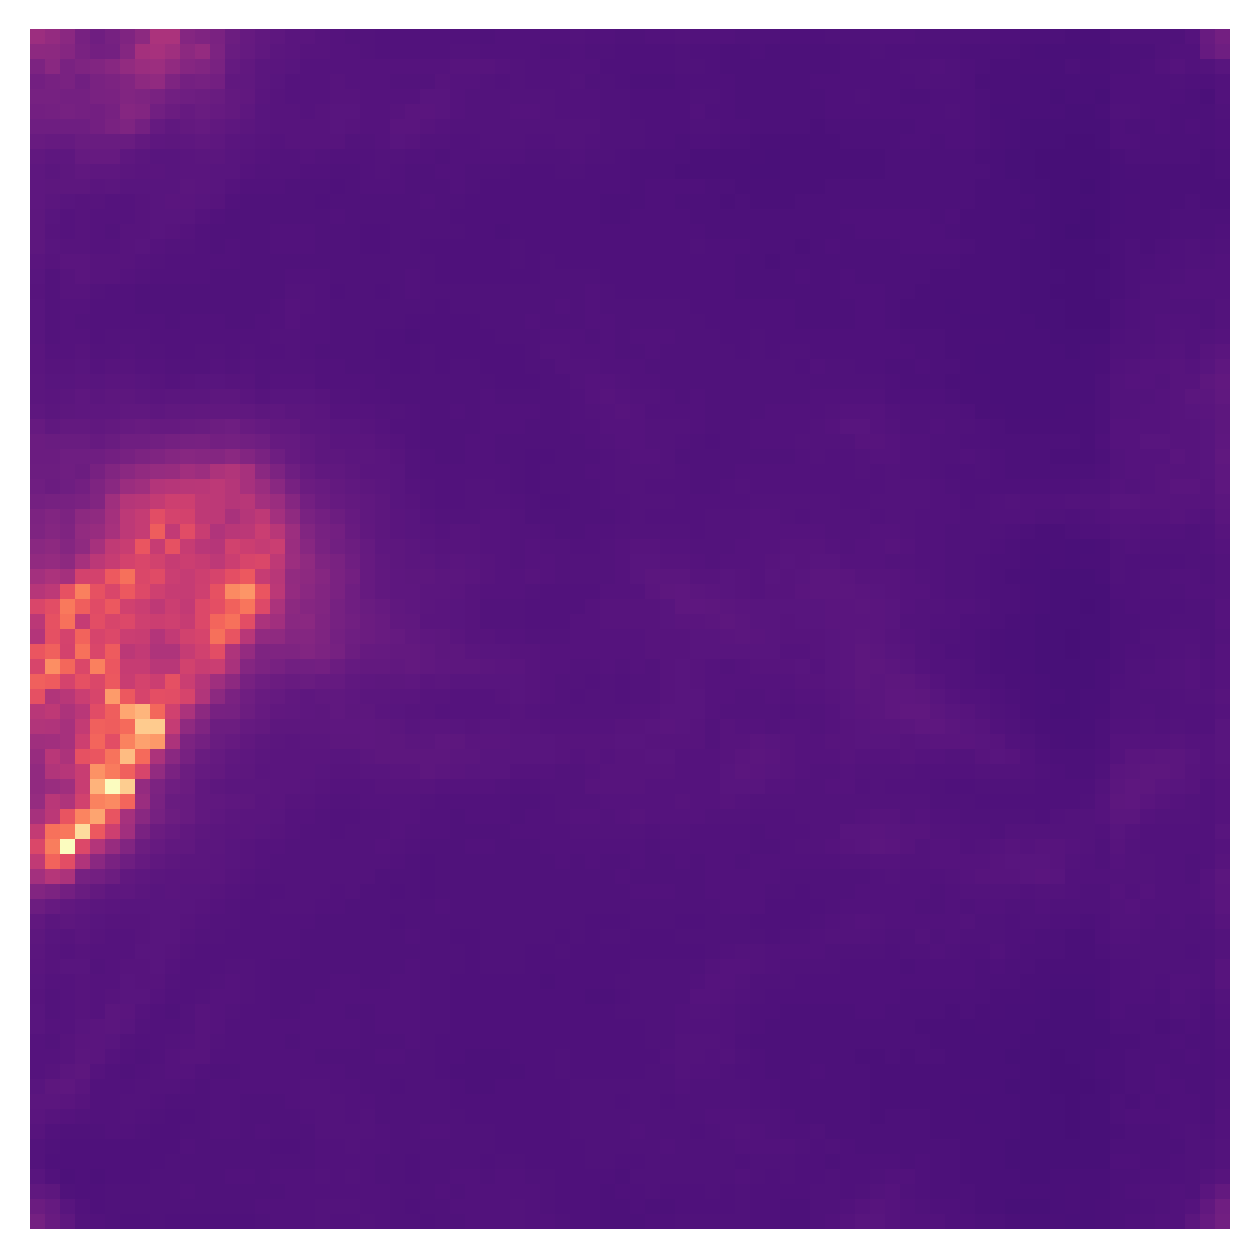

Saved schematic_sigma_zca.png


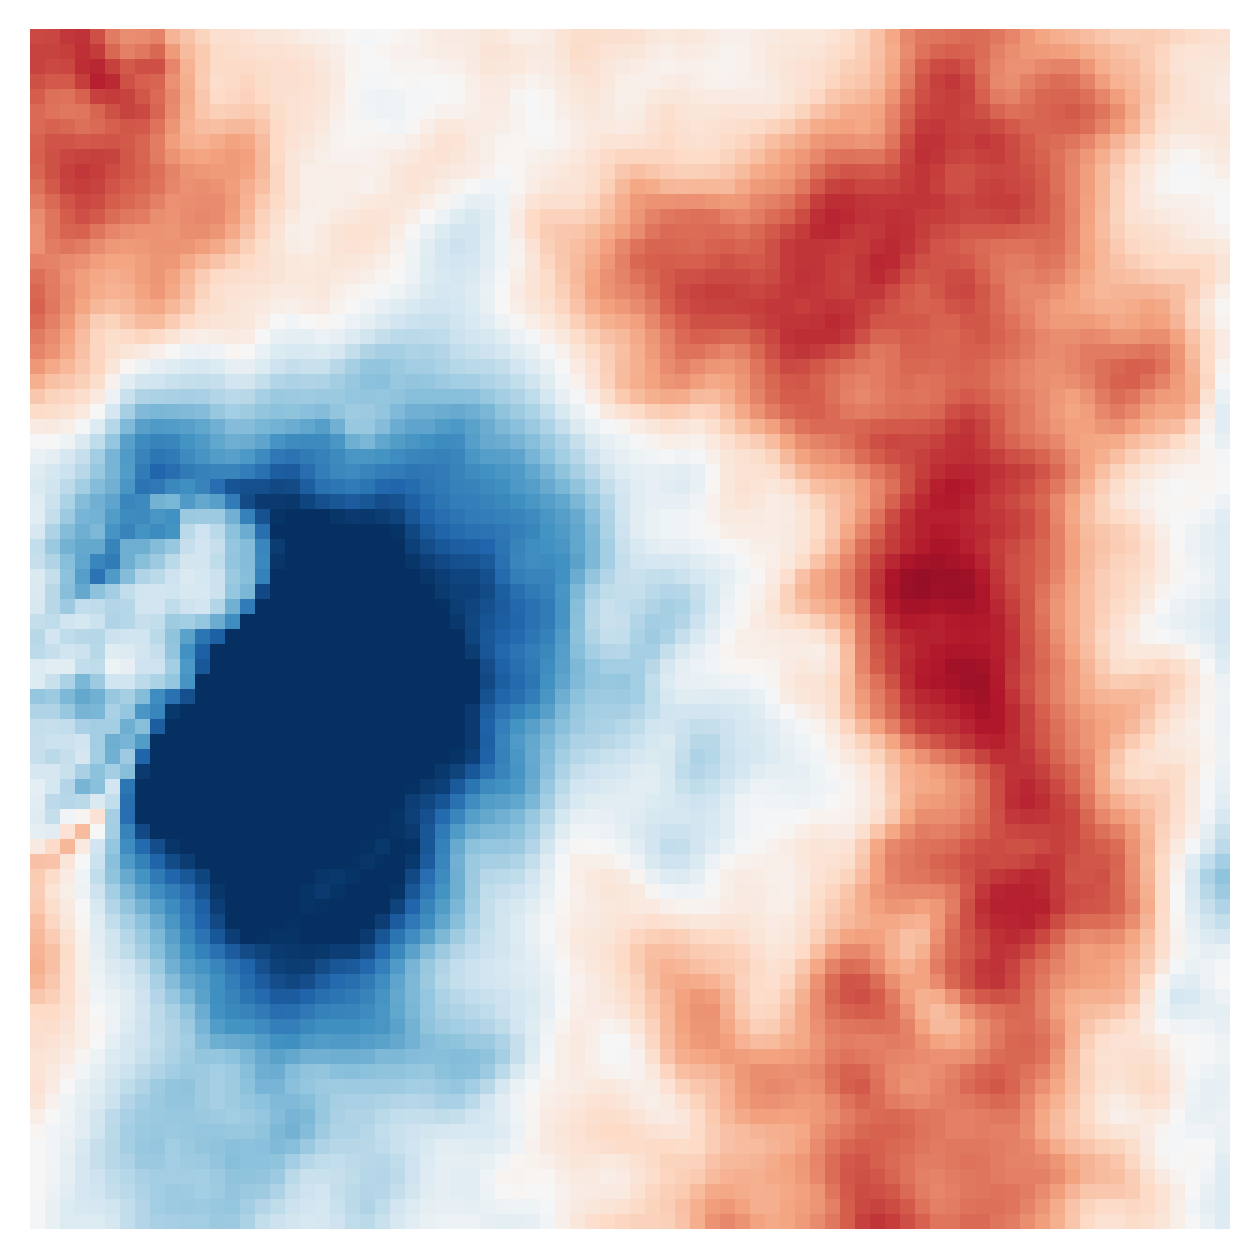

Saved schematic_ubm_pred.png


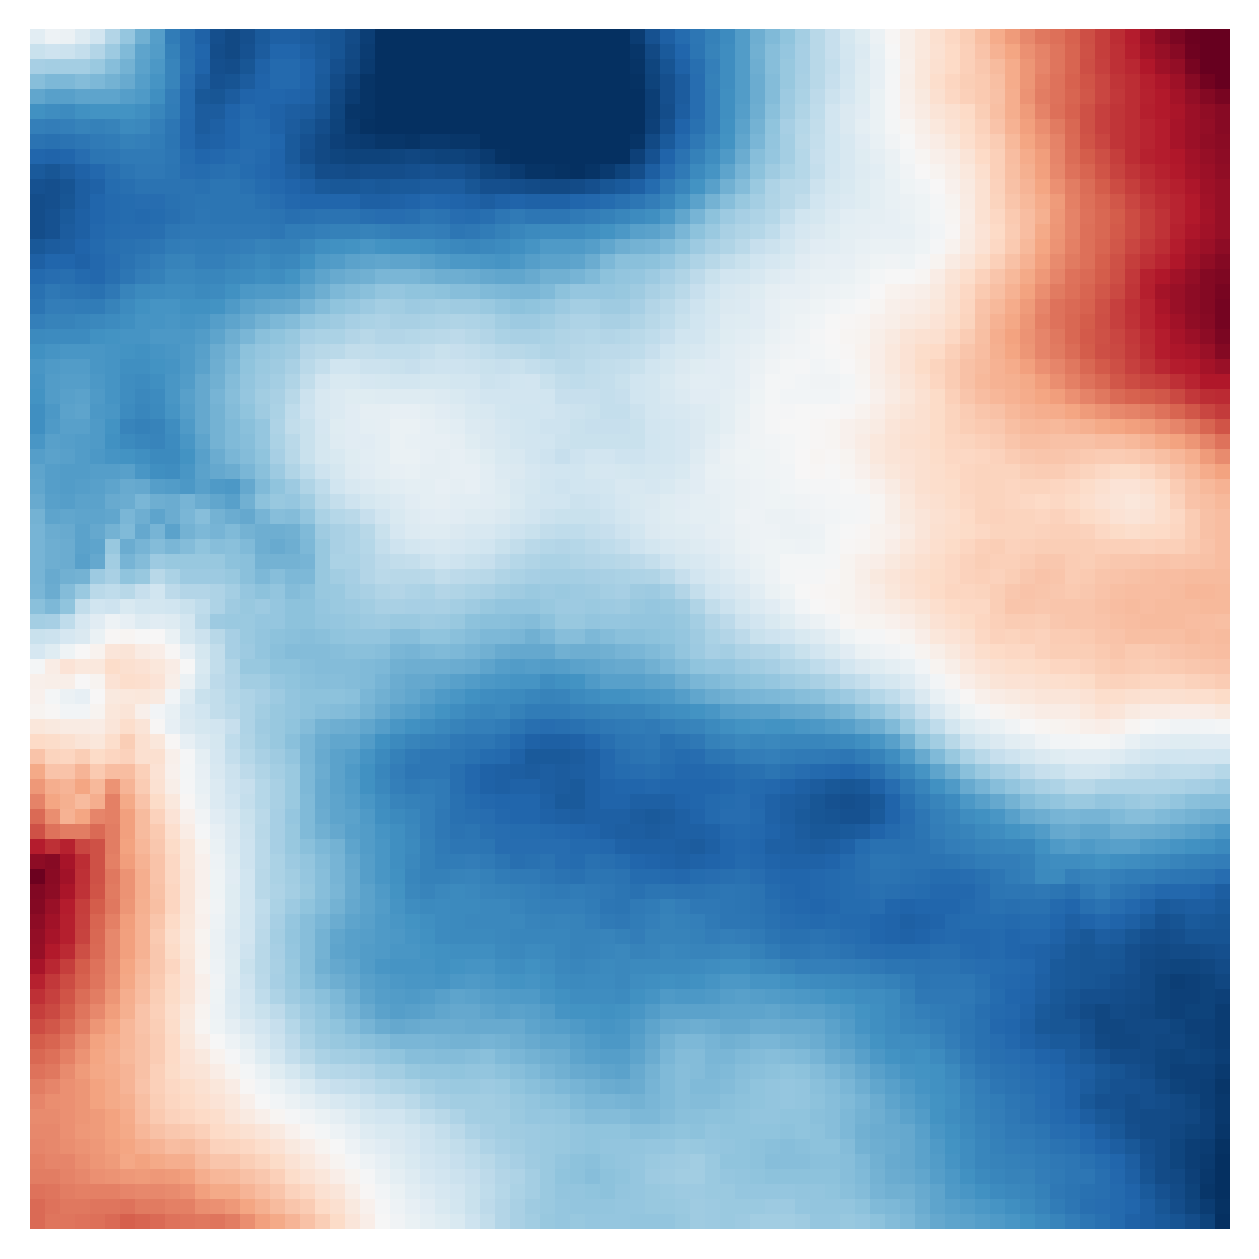

Saved schematic_bm_pred.png


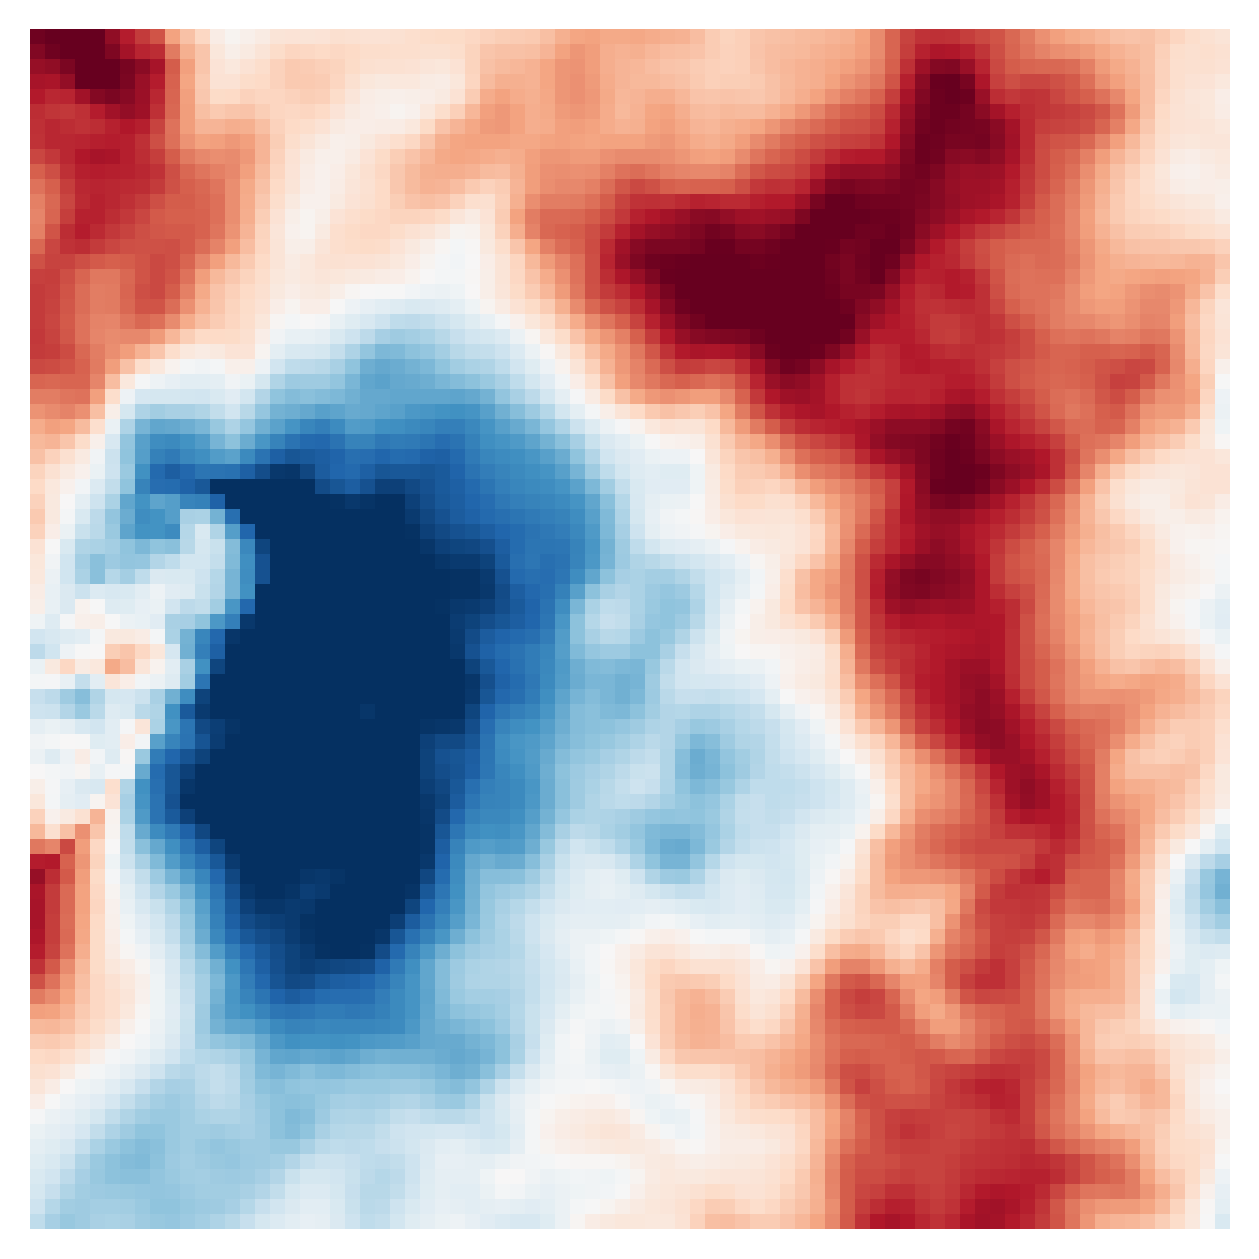

Saved schematic_ubm_true.png


In [34]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo

fields = {
    'ssh_input':   (ssh,       'RdBu_r',      -0.08,   0.015),
    'sst_input':   (sst,       'viridis',    11.6,    14),
    'mu_zca':      (mu_zca,    'cool',    -3.0,    3.0),
    'sigma_zca':   (sigma_zca, 'magma',        -1,     5.0),
    'ubm_pred':    (ubm_pred,  'RdBu_r',     -0.04,    0.04),
    'bm_pred':     (bm_pred,   'RdBu_r',     -0.08,    0.00),
    'ubm_true':    (ubm_true,  'RdBu_r',     -0.04,    0.04),
}


for name, (data, cmap, vmin, vmax) in fields.items():
    fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
    ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/schematic_{name}.png',
                dpi=300, bbox_inches='tight', facecolor='white', pad_inches=0.02)
    plt.show()
    print(f"Saved schematic_{name}.png")

In [19]:
for name, data in [('ssh', ssh), ('sst', sst), ('mu_zca', mu_zca), 
                    ('sigma_zca', sigma_zca), ('ubm_pred', ubm_pred), 
                    ('bm_pred', bm_pred), ('ubm_true', ubm_true)]:
    print(f"{name:12s}: min={np.nanmin(data):.4f}, max={np.nanmax(data):.4f}, mean={np.nanmean(data):.4f}")

ssh         : min=-0.1198, max=0.0122, mean=-0.0509
sst         : min=11.5165, max=14.0913, mean=12.4767
mu_zca      : min=-14.1017, max=17.9873, mean=0.0031
sigma_zca   : min=0.3554, max=5.8162, mean=0.6544
ubm_pred    : min=-0.0605, max=0.0349, mean=0.0008
bm_pred     : min=-0.0889, max=0.0032, mean=-0.0517
ubm_true    : min=-0.0540, max=0.0448, mean=0.0034
